Reference
- https://www.kaggle.com/ymlai87416/web-traffic-time-series-forecast-with-4-model
- https://github.com/jfpuget/Kaggle (this boilplate)

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/kaggle-web-traffic-time-series-forecasting/codes

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive/kaggle-web-traffic-time-series-forecasting/codes


In [0]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 600
from tqdm import tqdm
import gc

from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.decomposition import PCA

from keras.layers.normalization import BatchNormalization

from keras.models import Sequential, Model

from keras.layers import Input, Embedding, Dense, Activation, Dropout, Flatten

from keras import regularizers 

import keras

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GroupKFold


Using TensorFlow backend.


In [0]:
def init():
    np.random.seed = 0
    
init()

In [0]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.nanmean(diff)

def smape2D(y_true, y_pred):
    return smape(np.ravel(y_true), np.ravel(y_pred))
    
def smape_mask(y_true, y_pred, threshold):
    denominator = (np.abs(y_true) + np.abs(y_pred)) 
    diff = np.abs(y_true - y_pred) 
    diff[denominator == 0] = 0.0
    
    return diff <= (threshold / 2.0) * denominator

# def smape(y_true, y_pred, axis=None):
#     '''Symmetric mean absolute percentage error'''
#     diff = np.abs((y_true - y_pred) / 
#                   np.clip(np.abs(y_true) + np.abs(y_pred), np.float32(1e-07), None))
#     return np.float32(200.) * np.nanmean(diff, axis=axis)

## Basic information of the dataset

### Dataset
- 145K wiki page
- Training data from 2015-07-01 to 2017-09-10
- Testing data from 2017-09-13 to 2017-11-13


In [0]:
orig = pd.read_csv("../data/train_2.csv")
orig.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,...,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,2017-01-

In [0]:
def missing_values(df, percentage):

    columns = df.columns
    percent_missing = df[df.isnull()].sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    return missing_drop
#     df = df.drop(missing_drop, axis=1)
#     return df

print(missing_values(orig, 10))

[]


In [0]:
# Check the data
print("Check the number of records")
print("Number of records: ", orig.shape[0], "\n")

# It's actually lots of missing value
print("Null analysis")
empty_sample = orig[orig.isnull().any(axis=1)]
print("Number of records contain 1+ null: {} ({:.1%})".format(empty_sample.shape[0], empty_sample.shape[0]/orig.shape[0]))


Check the number of records
Number of records:  145063 

Null analysis
Number of records contain 1+ null: 29979 (20.7%)


### Page meta info break down

In [0]:
page_details = orig.Page.str.extract(r'(?P<topic>.*)\_(?P<lang>.*).wikipedia.org\_(?P<access>.*)\_(?P<type>.*)')
page_details[0:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


,topic,lang,access,type
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52_Hz_I_Love_You,zh,all-access,spider
5,5566,zh,all-access,spider
6,91Days,zh,all-access,spider
7,A'N'D,zh,all-access,spider
8,AKB48,zh,all-access,spider
9,ASCII,zh,all-access,spider


In [0]:
unique_topic = page_details["topic"].unique()
# print(unique_topic)
print("Number of distinct topics: ", unique_topic.shape[0])

Number of distinct topics:  42213


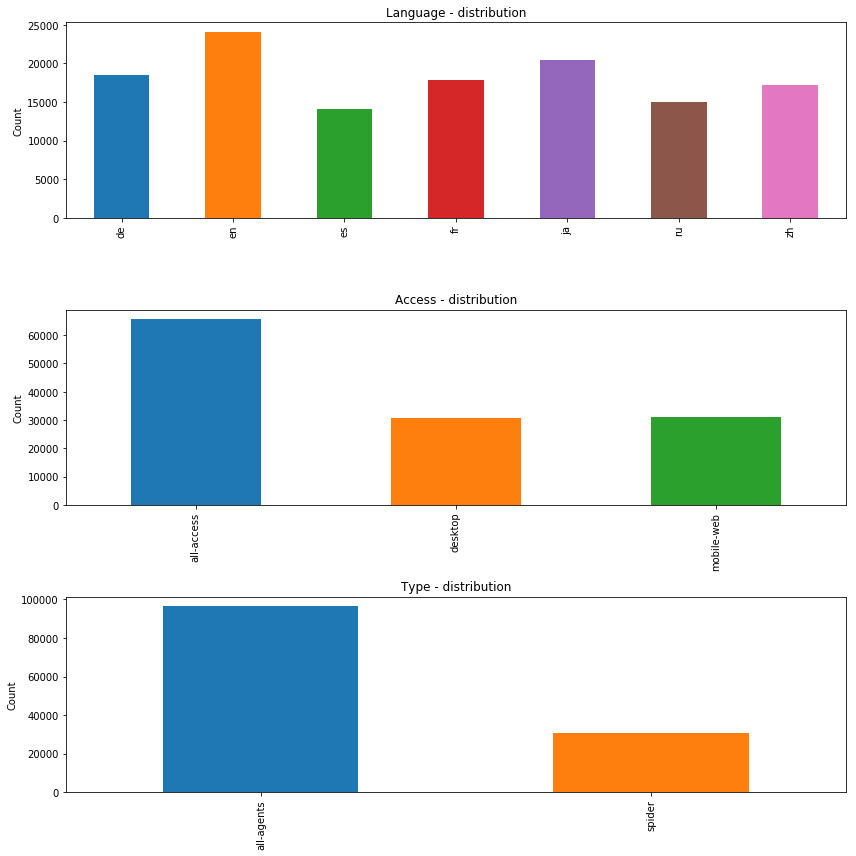

In [0]:
fig, axs  = plt.subplots(3,1,figsize=(12,12))

page_details["lang"].value_counts().sort_index().plot.bar(ax=axs[0])
axs[0].set_title('Language - distribution')

page_details["access"].value_counts().sort_index().plot.bar(ax=axs[1])
axs[1].set_title('Access - distribution')

page_details["type"].value_counts().sort_index().plot.bar(ax=axs[2])
axs[2].set_title('Type - distribution')

for ax in axs:
    ax.set_ylabel("Count")
plt.tight_layout()

## Prepare training and testing dataset and data cleaning

###Loading training dataset

In [0]:
# Downsampling
start, end = 0, 10000
orig = orig.iloc[start:end]

In [0]:
max_size = 366 # number of days in 2015 with 3 days before end
offset = 0.1

all_page = orig.Page.copy()
train_key = orig[['Page']].copy()
train_all = orig.copy()
train_all = train_all.iloc[:,1:] * offset
train_all.head()

,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,2015-08-09,2015-08-10,2015-08-11,2015-08-12,2015-08-13,2015-08-14,2015-08-15,2015-08-16,2015-08-17,2015-08-18,2015-08-19,2015-08-20,2015-08-21,2015-08-22,2015-08-23,2015-08-24,2015-08-25,2015-08-26,2015-08-27,2015-08-28,2015-08-29,2015-08-30,2015-08-31,2015-09-01,2015-09-02,2015-09-03,2015-09-04,2015-09-05,2015-09-06,2015-09-07,2015-09-08,2015-09-09,2015-09-10,2015-09-11,2015-09-12,2015-09-13,2015-09-14,2015-09-15,2015-09-16,2015-09-17,2015-09-18,2015-09-19,2015-09-20,2015-09-21,2015-09-22,2015-09-23,2015-09-24,2015-09-25,2015-09-26,2015-09-27,2015-09-28,2015-09-29,2015-09-30,2015-10-01,2015-10-02,2015-10-03,2015-10-04,2015-10-05,2015-10-06,2015-10-07,2015-10-08,2015-10-09,2015-10-10,2015-10-11,2015-10-12,2015-10-13,2015-10-14,2015-10-15,2015-10-16,2015-10-17,2015-10-18,2015-10-19,2015-10-20,2015-10-21,2015-10-22,2015-10-23,2015-10-24,2015-10-25,2015-10-26,2015-10-27,2015-10-28,2015-10-29,2015-10-30,2015-10-31,2015-11-01,2015-11-02,2015-11-03,2015-11-04,2015-11-05,2015-11-06,2015-11-07,2015-11-08,2015-11-09,2015-11-10,2015-11-11,2015-11-12,2015-11-13,2015-11-14,2015-11-15,2015-11-16,2015-11-17,2015-11-18,2015-11-19,2015-11-20,2015-11-21,2015-11-22,2015-11-23,2015-11-24,2015-11-25,2015-11-26,2015-11-27,2015-11-28,2015-11-29,2015-11-30,2015-12-01,2015-12-02,2015-12-03,2015-12-04,2015-12-05,2015-12-06,2015-12-07,2015-12-08,2015-12-09,2015-12-10,2015-12-11,2015-12-12,2015-12-13,2015-12-14,2015-12-15,2015-12-16,2015-12-17,2015-12-18,2015-12-19,2015-12-20,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-26,2015-12-27,2015-12-28,2015-12-29,2015-12-30,2015-12-31,2016-01-01,2016-01-02,2016-01-03,2016-01-04,2016-01-05,2016-01-06,2016-01-07,2016-01-08,2016-01-09,2016-01-10,2016-01-11,2016-01-12,2016-01-13,2016-01-14,2016-01-15,2016-01-16,2016-01-17,2016-01-18,2016-01-19,2016-01-20,2016-01-21,2016-01-22,2016-01-23,2016-01-24,2016-01-25,2016-01-26,2016-01-27,2016-01-28,2016-01-29,2016-01-30,2016-01-31,2016-02-01,2016-02-02,2016-02-03,2016-02-04,2016-02-05,2016-02-06,2016-02-07,2016-02-08,2016-02-09,2016-02-10,2016-02-11,2016-02-12,2016-02-13,2016-02-14,2016-02-15,2016-02-16,2016-02-17,2016-02-18,2016-02-19,2016-02-20,2016-02-21,2016-02-22,2016-02-23,2016-02-24,2016-02-25,2016-02-26,2016-02-27,2016-02-28,2016-02-29,2016-03-01,2016-03-02,2016-03-03,2016-03-04,2016-03-05,2016-03-06,2016-03-07,2016-03-08,2016-03-09,2016-03-10,2016-03-11,2016-03-12,2016-03-13,2016-03-14,2016-03-15,2016-03-16,2016-03-17,2016-03-18,2016-03-19,2016-03-20,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30,2016-03-31,2016-04-01,2016-04-02,2016-04-03,2016-04-04,2016-04-05,2016-04-06,2016-04-07,2016-04-08,2016-04-09,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24,2016-04-25,...,2016-11-15,2016-11-16,2016-11-17,2016-11-18,2016-11-19,2016-11-20,2016-11-21,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05,2017-01-06,2017-01-07,2017-01-08,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-14,2017-01-15,2017-01-16,20

In [0]:
def get_date_index(date, train_all=train_all):
    for idx, c in enumerate(train_all.columns):
        if date == c:
            break
    if idx == len(train_all.columns):
        return None
    return idx

In [0]:
get_date_index('2016-09-13')

440

In [0]:
get_date_index('2016-09-10')

437

In [0]:
train_all.shape[1] - get_date_index('2016-09-10')

366

In [0]:
get_date_index('2017-09-10') - get_date_index('2016-09-10')

365

### Split training dataset into training and testing
Train data is extract from the original data by the last 181 days

In [0]:
# Split the dataset into training and testing datasets
train_end = get_date_index('2016-09-10') + 1
test_start = get_date_index('2016-09-13')

train = train_all.iloc[ : , (train_end - max_size) : train_end].copy().astype('float32')
test = train_all.iloc[:, test_start : (63 + test_start)].copy().astype('float32')
train = train.iloc[:,::-1].copy().astype('float32')

train_all = train_all.iloc[:,-(max_size):].astype('float32')
train_all = train_all.iloc[:,::-1].copy().astype('float32')

for dataset in [orig, train_all, train, test]:
    print('shape: {}'.format(dataset.shape))

shape: (10000, 804)
shape: (10000, 366)
shape: (10000, 366)
shape: (10000, 63)


In [0]:
train_all.head()

,2017-09-10,2017-09-09,2017-09-08,2017-09-07,2017-09-06,2017-09-05,2017-09-04,2017-09-03,2017-09-02,2017-09-01,2017-08-31,2017-08-30,2017-08-29,2017-08-28,2017-08-27,2017-08-26,2017-08-25,2017-08-24,2017-08-23,2017-08-22,2017-08-21,2017-08-20,2017-08-19,2017-08-18,2017-08-17,2017-08-16,2017-08-15,2017-08-14,2017-08-13,2017-08-12,2017-08-11,2017-08-10,2017-08-09,2017-08-08,2017-08-07,2017-08-06,2017-08-05,2017-08-04,2017-08-03,2017-08-02,2017-08-01,2017-07-31,2017-07-30,2017-07-29,2017-07-28,2017-07-27,2017-07-26,2017-07-25,2017-07-24,2017-07-23,2017-07-22,2017-07-21,2017-07-20,2017-07-19,2017-07-18,2017-07-17,2017-07-16,2017-07-15,2017-07-14,2017-07-13,2017-07-12,2017-07-11,2017-07-10,2017-07-09,2017-07-08,2017-07-07,2017-07-06,2017-07-05,2017-07-04,2017-07-03,2017-07-02,2017-07-01,2017-06-30,2017-06-29,2017-06-28,2017-06-27,2017-06-26,2017-06-25,2017-06-24,2017-06-23,2017-06-22,2017-06-21,2017-06-20,2017-06-19,2017-06-18,2017-06-17,2017-06-16,2017-06-15,2017-06-14,2017-06-13,2017-06-12,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01,2017-05-31,2017-05-30,2017-05-29,2017-05-28,2017-05-27,2017-05-26,2017-05-25,2017-05-24,2017-05-23,2017-05-22,2017-05-21,2017-05-20,2017-05-19,2017-05-18,2017-05-17,2017-05-16,2017-05-15,2017-05-14,2017-05-13,2017-05-12,2017-05-11,2017-05-10,2017-05-09,2017-05-08,2017-05-07,2017-05-06,2017-05-05,2017-05-04,2017-05-03,2017-05-02,2017-05-01,2017-04-30,2017-04-29,2017-04-28,2017-04-27,2017-04-26,2017-04-25,2017-04-24,2017-04-23,2017-04-22,2017-04-21,2017-04-20,2017-04-19,2017-04-18,2017-04-17,2017-04-16,2017-04-15,2017-04-14,2017-04-13,2017-04-12,2017-04-11,2017-04-10,2017-04-09,2017-04-08,2017-04-07,2017-04-06,2017-04-05,2017-04-04,2017-04-03,2017-04-02,2017-04-01,2017-03-31,2017-03-30,2017-03-29,2017-03-28,2017-03-27,2017-03-26,2017-03-25,2017-03-24,2017-03-23,2017-03-22,2017-03-21,2017-03-20,2017-03-19,2017-03-18,2017-03-17,2017-03-16,2017-03-15,2017-03-14,2017-03-13,2017-03-12,2017-03-11,2017-03-10,2017-03-09,2017-03-08,2017-03-07,2017-03-06,2017-03-05,2017-03-04,2017-03-03,2017-03-02,2017-03-01,2017-02-28,2017-02-27,2017-02-26,2017-02-25,2017-02-24,2017-02-23,2017-02-22,2017-02-21,2017-02-20,2017-02-19,2017-02-18,2017-02-17,2017-02-16,2017-02-15,2017-02-14,2017-02-13,2017-02-12,2017-02-11,2017-02-10,2017-02-09,2017-02-08,2017-02-07,2017-02-06,2017-02-05,2017-02-04,2017-02-03,2017-02-02,2017-02-01,2017-01-31,2017-01-30,2017-01-29,2017-01-28,2017-01-27,2017-01-26,2017-01-25,2017-01-24,2017-01-23,2017-01-22,2017-01-21,2017-01-20,2017-01-19,2017-01-18,2017-01-17,2017-01-16,2017-01-15,2017-01-14,2017-01-13,2017-01-12,2017-01-11,2017-01-10,2017-01-09,2017-01-08,2017-01-07,2017-01-06,2017-01-05,2017-01-04,2017-01-03,2017-01-02,2017-01-01,2016-12-31,2016-12-30,2016-12-29,2016-12-28,2016-12-27,2016-12-26,2016-12-25,2016-12-24,2016-12-23,2016-12-22,2016-12-21,2016-12-20,2016-12-19,2016-12-18,2016-12-17,2016-12-16,2016-12-15,2016-12-14,2016-12-13,2016-12-12,2016-12-11,2016-12-10,2016-12-09,2016-12-08,2016-12-07,2016-12-06,2016-12-05,2016-12-04,2016-12-03,2016-12-02,2016-12-01,2016-11-30,2016-11-29,2016-11-28,2016-11-27,2016-11-26,2016-11-25,2016-11-24,2016-11-23,2016-11-22,2016-11-21,2016-11-20,2016-11-19,2016-11-18,2016-11-17,2016-11-16,2016-11-15,2016-11-14,2016-11-13,2016-11-12,2016-11-11,2016-11-10,2016-11-09,2016-11-08,2016-11-07,2016-11-06,2016-11-05,2016-11-04,2016-11-03,2016-11-02,2016-11-01,2016-10-31,2016-10-30,2016-10-29,2016-10-28,2016-10-27,2016-10-26,2016-10-25,2016-10-24,2016-10-23,2016-10-22,2016-10-21,2016-10-20,2016-10-19,2016-10-18,2016-10-17,2016-10-16,2016-10-15,2016-10-14,2016-10-13,2016-10-12,2016-10-11,2016-10-10,2016-10-09,2016-10-08,2016-10-07,2016-10-06,2016-10-05,2016-10-04,2016-10-03,2016-10-02,2016-10-01,2016-09-30,2016-09-29,2016-09-28,2016-09-27,2016-09-26,2016-09-25,2016-09-24,2016-09-23,2016-09-22,2016-09-21,2016-09-20,2016-09-19,2016-09-18,2016-09-17,2016-09-16,2016-09-15,2016-09-14,2016-09-13,2016-0

In [0]:
train.head()

,2016-09-10,2016-09-09,2016-09-08,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,2016-07-22,2016-07-21,2016-07-20,2016-07-19,2016-07-18,2016-07-17,2016-07-16,2016-07-15,2016-07-14,2016-07-13,2016-07-12,2016-07-11,2016-07-10,2016-07-09,2016-07-08,2016-07-07,2016-07-06,2016-07-05,2016-07-04,2016-07-03,2016-07-02,2016-07-01,2016-06-30,2016-06-29,2016-06-28,2016-06-27,2016-06-26,2016-06-25,2016-06-24,2016-06-23,2016-06-22,2016-06-21,2016-06-20,2016-06-19,2016-06-18,2016-06-17,2016-06-16,2016-06-15,2016-06-14,2016-06-13,2016-06-12,2016-06-11,2016-06-10,2016-06-09,2016-06-08,2016-06-07,2016-06-06,2016-06-05,2016-06-04,2016-06-03,2016-06-02,2016-06-01,2016-05-31,2016-05-30,2016-05-29,2016-05-28,2016-05-27,2016-05-26,2016-05-25,2016-05-24,2016-05-23,2016-05-22,2016-05-21,2016-05-20,2016-05-19,2016-05-18,2016-05-17,2016-05-16,2016-05-15,2016-05-14,2016-05-13,2016-05-12,2016-05-11,2016-05-10,2016-05-09,2016-05-08,2016-05-07,2016-05-06,2016-05-05,2016-05-04,2016-05-03,2016-05-02,2016-05-01,2016-04-30,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14,2016-03-13,2016-03-12,2016-03-11,2016-03-10,2016-03-09,2016-03-08,2016-03-07,2016-03-06,2016-03-05,2016-03-04,2016-03-03,2016-03-02,2016-03-01,2016-02-29,2016-02-28,2016-02-27,2016-02-26,2016-02-25,2016-02-24,2016-02-23,2016-02-22,2016-02-21,2016-02-20,2016-02-19,2016-02-18,2016-02-17,2016-02-16,2016-02-15,2016-02-14,2016-02-13,2016-02-12,2016-02-11,2016-02-10,2016-02-09,2016-02-08,2016-02-07,2016-02-06,2016-02-05,2016-02-04,2016-02-03,2016-02-02,2016-02-01,2016-01-31,2016-01-30,2016-01-29,2016-01-28,2016-01-27,2016-01-26,2016-01-25,2016-01-24,2016-01-23,2016-01-22,2016-01-21,2016-01-20,2016-01-19,2016-01-18,2016-01-17,2016-01-16,2016-01-15,2016-01-14,2016-01-13,2016-01-12,2016-01-11,2016-01-10,2016-01-09,2016-01-08,2016-01-07,2016-01-06,2016-01-05,2016-01-04,2016-01-03,2016-01-02,2016-01-01,2015-12-31,2015-12-30,2015-12-29,2015-12-28,2015-12-27,2015-12-26,2015-12-25,2015-12-24,2015-12-23,2015-12-22,2015-12-21,2015-12-20,2015-12-19,2015-12-18,2015-12-17,2015-12-16,2015-12-15,2015-12-14,2015-12-13,2015-12-12,2015-12-11,2015-12-10,2015-12-09,2015-12-08,2015-12-07,2015-12-06,2015-12-05,2015-12-04,2015-12-03,2015-12-02,2015-12-01,2015-11-30,2015-11-29,2015-11-28,2015-11-27,2015-11-26,2015-11-25,2015-11-24,2015-11-23,2015-11-22,2015-11-21,2015-11-20,2015-11-19,2015-11-18,2015-11-17,2015-11-16,2015-11-15,2015-11-14,2015-11-13,2015-11-12,2015-11-11,2015-11-10,2015-11-09,2015-11-08,2015-11-07,2015-11-06,2015-11-05,2015-11-04,2015-11-03,2015-11-02,2015-11-01,2015-10-31,2015-10-30,2015-10-29,2015-10-28,2015-10-27,2015-10-26,2015-10-25,2015-10-24,2015-10-23,2015-10-22,2015-10-21,2015-10-20,2015-10-19,2015-10-18,2015-10-17,2015-10-16,2015-10-15,2015-10-14,2015-10-13,2015-10-12,2015-10-11,2015-10-10,2015-10-09,2015-10-08,2015-10-07,2015-10-06,2015-10-05,2015-10-04,2015-10-03,2015-10-02,2015-10-01,2015-09-30,2015-09-29,2015-09-28,2015-09-27,2015-09-26,2015-09-25,2015-09-24,2015-09-23,2015-09-22,2015-09-21,2015-09-20,2015-09-19,2015-09-18,2015-09-17,2015-09-16,2015-09-15,2015-09-14,2015-0

In [0]:
test.head()

,2016-09-13,2016-09-14,2016-09-15,2016-09-16,2016-09-17,2016-09-18,2016-09-19,2016-09-20,2016-09-21,2016-09-22,2016-09-23,2016-09-24,2016-09-25,2016-09-26,2016-09-27,2016-09-28,2016-09-29,2016-09-30,2016-10-01,2016-10-02,2016-10-03,2016-10-04,2016-10-05,2016-10-06,2016-10-07,2016-10-08,2016-10-09,2016-10-10,2016-10-11,2016-10-12,2016-10-13,2016-10-14,2016-10-15,2016-10-16,2016-10-17,2016-10-18,2016-10-19,2016-10-20,2016-10-21,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31,2016-11-01,2016-11-02,2016-11-03,2016-11-04,2016-11-05,2016-11-06,2016-11-07,2016-11-08,2016-11-09,2016-11-10,2016-11-11,2016-11-12,2016-11-13,2016-11-14
0,1.1,1.3,2.0,2.1,1.3,2.4,2.0,1.3,3.2,1.6,1.0,1.3,4.4,1.7,1.3,7.2,4.0,1.9,1.4,1.3,1.2,1.4,1.0,2.6,1.3,2.2,1.4,2.3,1.2,0.8,5.0,1.3,1.0,1.6,1.4,1.0,2.4,1.0,2.0,1.0,2.6,2.5,1.6,1.900000,2.0,1.2,1.9,5.0,1.6,3.0,1.8,2.5,1.4,2.0,0.8,6.7,1.3,4.1,1.0,2.1,1.3,0.8,1.5
1,3.7,3.8,2.2,2.8,1.9,4.6,2.4,2.2,4.3,5.8,2.6,2.0,2.7,3.5,2.0,3.1,2.4,2.4,9.4,1.8,2.0,1.8,1.6,3.8,5.4,2.9,4.9,2.5,7.2,14.4,3.6,9.7,17.9,2.9,1.2,2.1,4.2,5.3,4.1,1.9,2.5,1.9,1.5,2.100000,2.1,2.7,3.3,1.5,2.4,1.3,1.1,1.4,2.6,1.1,2.1,1.4,1.4,5.4,0.5,1.0,1.2,1.1,1.4
2,0.4,1.0,0.3,0.4,0.6,0.3,0.4,0.8,1.0,0.3,0.3,0.1,1.0,0.5,0.4,0.4,0.3,0.4,0.1,0.3,0.6,0.6,0.6,0.3,0.5,1.1,0.6,0.3,0.7,0.6,0.0,0.2,0.4,0.4,0.3,0.6,0.4,0.3,0.4,0.1,0.6,0.5,0.5,0.200000,0.3,0.3,0.2,0.2,0.6,0.1,0.3,0.3,0.3,0.2,1.0,0.2,0.2,0.2,0.7,0.3,0.6,0.4,0.2
3,1.1,1.5,2.8,1.0,2.4,0.8,2.0,1.9,1.2,3.1,1.4,0.9,4.0,1.5,8.3,6.0,1.9,1.5,1.5,1.2,2.3,1.7,2.0,2.6,1.1,1.3,0.9,4.4,0.7,1.8,0.4,3.6,3.4,1.0,0.8,2.1,0.7,0.6,1.2,1.5,0.9,1.3,2.1,1.300000,1.0,2.1,1.5,10.3,2.2,1.5,1.2,1.1,1.5,0.7,1.2,1.3,0.9,0.8,2.1,1.6,3.8,1.3,1.4
4,1.3,6.3,0.2,0.2,0.3,0.6,1.0,0.2,0.8,0.4,0.3,0.3,0.6,0.4,0.1,0.5,0.9,0.1,0.6,0.4,0.0,0.4,0.9,0.6,0.8,1.3,0.4,0.7,0.6,0.9,0.3,2.1,0.6,1.3,1.0,0.2,0.3,0.6,0.7,1.0,0.6,0.6,0.4,17.299999,0.5,1.0,1.0,1.8,2.0,1.1,0.5,0.6,3.3,1.3,1.0,2.2,1.1,0.8,0.4,1.0,1.3,1.1,0.8


### Feature Engineering

In [0]:
data = [page.split('_') for page in tqdm(train_key.Page)]

access = ['_'.join(page[-2:]) for page in data]

site = [page[-3][:2] for page in data]

page = ['_'.join(page[:-3]) for page in data]
page[:2]

train_key['PageTitle'] = page
train_key['Site'] = site
train_key['AccessAgent'] = access
train_key.head()

100%|██████████| 10000/10000 [00:00<00:00, 352687.77it/s]


,Page,PageTitle,Site,AccessAgent
0,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access_spider
1,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access_spider
2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access_spider
3,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access_spider
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You,zh,all-access_spider


In [0]:
train_norm = np.log1p(train).astype('float32')
train_norm.head()

,2016-09-10,2016-09-09,2016-09-08,2016-09-07,2016-09-06,2016-09-05,2016-09-04,2016-09-03,2016-09-02,2016-09-01,2016-08-31,2016-08-30,2016-08-29,2016-08-28,2016-08-27,2016-08-26,2016-08-25,2016-08-24,2016-08-23,2016-08-22,2016-08-21,2016-08-20,2016-08-19,2016-08-18,2016-08-17,2016-08-16,2016-08-15,2016-08-14,2016-08-13,2016-08-12,2016-08-11,2016-08-10,2016-08-09,2016-08-08,2016-08-07,2016-08-06,2016-08-05,2016-08-04,2016-08-03,2016-08-02,2016-08-01,2016-07-31,2016-07-30,2016-07-29,2016-07-28,2016-07-27,2016-07-26,2016-07-25,2016-07-24,2016-07-23,2016-07-22,2016-07-21,2016-07-20,2016-07-19,2016-07-18,2016-07-17,2016-07-16,2016-07-15,2016-07-14,2016-07-13,2016-07-12,2016-07-11,2016-07-10,2016-07-09,2016-07-08,2016-07-07,2016-07-06,2016-07-05,2016-07-04,2016-07-03,2016-07-02,2016-07-01,2016-06-30,2016-06-29,2016-06-28,2016-06-27,2016-06-26,2016-06-25,2016-06-24,2016-06-23,2016-06-22,2016-06-21,2016-06-20,2016-06-19,2016-06-18,2016-06-17,2016-06-16,2016-06-15,2016-06-14,2016-06-13,2016-06-12,2016-06-11,2016-06-10,2016-06-09,2016-06-08,2016-06-07,2016-06-06,2016-06-05,2016-06-04,2016-06-03,2016-06-02,2016-06-01,2016-05-31,2016-05-30,2016-05-29,2016-05-28,2016-05-27,2016-05-26,2016-05-25,2016-05-24,2016-05-23,2016-05-22,2016-05-21,2016-05-20,2016-05-19,2016-05-18,2016-05-17,2016-05-16,2016-05-15,2016-05-14,2016-05-13,2016-05-12,2016-05-11,2016-05-10,2016-05-09,2016-05-08,2016-05-07,2016-05-06,2016-05-05,2016-05-04,2016-05-03,2016-05-02,2016-05-01,2016-04-30,2016-04-29,2016-04-28,2016-04-27,2016-04-26,2016-04-25,2016-04-24,2016-04-23,2016-04-22,2016-04-21,2016-04-20,2016-04-19,2016-04-18,2016-04-17,2016-04-16,2016-04-15,2016-04-14,2016-04-13,2016-04-12,2016-04-11,2016-04-10,2016-04-09,2016-04-08,2016-04-07,2016-04-06,2016-04-05,2016-04-04,2016-04-03,2016-04-02,2016-04-01,2016-03-31,2016-03-30,2016-03-29,2016-03-28,2016-03-27,2016-03-26,2016-03-25,2016-03-24,2016-03-23,2016-03-22,2016-03-21,2016-03-20,2016-03-19,2016-03-18,2016-03-17,2016-03-16,2016-03-15,2016-03-14,2016-03-13,2016-03-12,2016-03-11,2016-03-10,2016-03-09,2016-03-08,2016-03-07,2016-03-06,2016-03-05,2016-03-04,2016-03-03,2016-03-02,2016-03-01,2016-02-29,2016-02-28,2016-02-27,2016-02-26,2016-02-25,2016-02-24,2016-02-23,2016-02-22,2016-02-21,2016-02-20,2016-02-19,2016-02-18,2016-02-17,2016-02-16,2016-02-15,2016-02-14,2016-02-13,2016-02-12,2016-02-11,2016-02-10,2016-02-09,2016-02-08,2016-02-07,2016-02-06,2016-02-05,2016-02-04,2016-02-03,2016-02-02,2016-02-01,2016-01-31,2016-01-30,2016-01-29,2016-01-28,2016-01-27,2016-01-26,2016-01-25,2016-01-24,2016-01-23,2016-01-22,2016-01-21,2016-01-20,2016-01-19,2016-01-18,2016-01-17,2016-01-16,2016-01-15,2016-01-14,2016-01-13,2016-01-12,2016-01-11,2016-01-10,2016-01-09,2016-01-08,2016-01-07,2016-01-06,2016-01-05,2016-01-04,2016-01-03,2016-01-02,2016-01-01,2015-12-31,2015-12-30,2015-12-29,2015-12-28,2015-12-27,2015-12-26,2015-12-25,2015-12-24,2015-12-23,2015-12-22,2015-12-21,2015-12-20,2015-12-19,2015-12-18,2015-12-17,2015-12-16,2015-12-15,2015-12-14,2015-12-13,2015-12-12,2015-12-11,2015-12-10,2015-12-09,2015-12-08,2015-12-07,2015-12-06,2015-12-05,2015-12-04,2015-12-03,2015-12-02,2015-12-01,2015-11-30,2015-11-29,2015-11-28,2015-11-27,2015-11-26,2015-11-25,2015-11-24,2015-11-23,2015-11-22,2015-11-21,2015-11-20,2015-11-19,2015-11-18,2015-11-17,2015-11-16,2015-11-15,2015-11-14,2015-11-13,2015-11-12,2015-11-11,2015-11-10,2015-11-09,2015-11-08,2015-11-07,2015-11-06,2015-11-05,2015-11-04,2015-11-03,2015-11-02,2015-11-01,2015-10-31,2015-10-30,2015-10-29,2015-10-28,2015-10-27,2015-10-26,2015-10-25,2015-10-24,2015-10-23,2015-10-22,2015-10-21,2015-10-20,2015-10-19,2015-10-18,2015-10-17,2015-10-16,2015-10-15,2015-10-14,2015-10-13,2015-10-12,2015-10-11,2015-10-10,2015-10-09,2015-10-08,2015-10-07,2015-10-06,2015-10-05,2015-10-04,2015-10-03,2015-10-02,2015-10-01,2015-09-30,2015-09-29,2015-09-28,2015-09-27,2015-09-26,2015-09-25,2015-09-24,2015-09-23,2015-09-22,2015-09-21,2015-09-20,2015-09-19,2015-09-18,2015-09-17,2015-09-16,2015-09-15,2015-09-14,2015-0

In [0]:
train_all_norm = np.log1p(train_all).fillna(0).astype('float32')
train_all_norm.head()

,2017-09-10,2017-09-09,2017-09-08,2017-09-07,2017-09-06,2017-09-05,2017-09-04,2017-09-03,2017-09-02,2017-09-01,2017-08-31,2017-08-30,2017-08-29,2017-08-28,2017-08-27,2017-08-26,2017-08-25,2017-08-24,2017-08-23,2017-08-22,2017-08-21,2017-08-20,2017-08-19,2017-08-18,2017-08-17,2017-08-16,2017-08-15,2017-08-14,2017-08-13,2017-08-12,2017-08-11,2017-08-10,2017-08-09,2017-08-08,2017-08-07,2017-08-06,2017-08-05,2017-08-04,2017-08-03,2017-08-02,2017-08-01,2017-07-31,2017-07-30,2017-07-29,2017-07-28,2017-07-27,2017-07-26,2017-07-25,2017-07-24,2017-07-23,2017-07-22,2017-07-21,2017-07-20,2017-07-19,2017-07-18,2017-07-17,2017-07-16,2017-07-15,2017-07-14,2017-07-13,2017-07-12,2017-07-11,2017-07-10,2017-07-09,2017-07-08,2017-07-07,2017-07-06,2017-07-05,2017-07-04,2017-07-03,2017-07-02,2017-07-01,2017-06-30,2017-06-29,2017-06-28,2017-06-27,2017-06-26,2017-06-25,2017-06-24,2017-06-23,2017-06-22,2017-06-21,2017-06-20,2017-06-19,2017-06-18,2017-06-17,2017-06-16,2017-06-15,2017-06-14,2017-06-13,2017-06-12,2017-06-11,2017-06-10,2017-06-09,2017-06-08,2017-06-07,2017-06-06,2017-06-05,2017-06-04,2017-06-03,2017-06-02,2017-06-01,2017-05-31,2017-05-30,2017-05-29,2017-05-28,2017-05-27,2017-05-26,2017-05-25,2017-05-24,2017-05-23,2017-05-22,2017-05-21,2017-05-20,2017-05-19,2017-05-18,2017-05-17,2017-05-16,2017-05-15,2017-05-14,2017-05-13,2017-05-12,2017-05-11,2017-05-10,2017-05-09,2017-05-08,2017-05-07,2017-05-06,2017-05-05,2017-05-04,2017-05-03,2017-05-02,2017-05-01,2017-04-30,2017-04-29,2017-04-28,2017-04-27,2017-04-26,2017-04-25,2017-04-24,2017-04-23,2017-04-22,2017-04-21,2017-04-20,2017-04-19,2017-04-18,2017-04-17,2017-04-16,2017-04-15,2017-04-14,2017-04-13,2017-04-12,2017-04-11,2017-04-10,2017-04-09,2017-04-08,2017-04-07,2017-04-06,2017-04-05,2017-04-04,2017-04-03,2017-04-02,2017-04-01,2017-03-31,2017-03-30,2017-03-29,2017-03-28,2017-03-27,2017-03-26,2017-03-25,2017-03-24,2017-03-23,2017-03-22,2017-03-21,2017-03-20,2017-03-19,2017-03-18,2017-03-17,2017-03-16,2017-03-15,2017-03-14,2017-03-13,2017-03-12,2017-03-11,2017-03-10,2017-03-09,2017-03-08,2017-03-07,2017-03-06,2017-03-05,2017-03-04,2017-03-03,2017-03-02,2017-03-01,2017-02-28,2017-02-27,2017-02-26,2017-02-25,2017-02-24,2017-02-23,2017-02-22,2017-02-21,2017-02-20,2017-02-19,2017-02-18,2017-02-17,2017-02-16,2017-02-15,2017-02-14,2017-02-13,2017-02-12,2017-02-11,2017-02-10,2017-02-09,2017-02-08,2017-02-07,2017-02-06,2017-02-05,2017-02-04,2017-02-03,2017-02-02,2017-02-01,2017-01-31,2017-01-30,2017-01-29,2017-01-28,2017-01-27,2017-01-26,2017-01-25,2017-01-24,2017-01-23,2017-01-22,2017-01-21,2017-01-20,2017-01-19,2017-01-18,2017-01-17,2017-01-16,2017-01-15,2017-01-14,2017-01-13,2017-01-12,2017-01-11,2017-01-10,2017-01-09,2017-01-08,2017-01-07,2017-01-06,2017-01-05,2017-01-04,2017-01-03,2017-01-02,2017-01-01,2016-12-31,2016-12-30,2016-12-29,2016-12-28,2016-12-27,2016-12-26,2016-12-25,2016-12-24,2016-12-23,2016-12-22,2016-12-21,2016-12-20,2016-12-19,2016-12-18,2016-12-17,2016-12-16,2016-12-15,2016-12-14,2016-12-13,2016-12-12,2016-12-11,2016-12-10,2016-12-09,2016-12-08,2016-12-07,2016-12-06,2016-12-05,2016-12-04,2016-12-03,2016-12-02,2016-12-01,2016-11-30,2016-11-29,2016-11-28,2016-11-27,2016-11-26,2016-11-25,2016-11-24,2016-11-23,2016-11-22,2016-11-21,2016-11-20,2016-11-19,2016-11-18,2016-11-17,2016-11-16,2016-11-15,2016-11-14,2016-11-13,2016-11-12,2016-11-11,2016-11-10,2016-11-09,2016-11-08,2016-11-07,2016-11-06,2016-11-05,2016-11-04,2016-11-03,2016-11-02,2016-11-01,2016-10-31,2016-10-30,2016-10-29,2016-10-28,2016-10-27,2016-10-26,2016-10-25,2016-10-24,2016-10-23,2016-10-22,2016-10-21,2016-10-20,2016-10-19,2016-10-18,2016-10-17,2016-10-16,2016-10-15,2016-10-14,2016-10-13,2016-10-12,2016-10-11,2016-10-10,2016-10-09,2016-10-08,2016-10-07,2016-10-06,2016-10-05,2016-10-04,2016-10-03,2016-10-02,2016-10-01,2016-09-30,2016-09-29,2016-09-28,2016-09-27,2016-09-26,2016-09-25,2016-09-24,2016-09-23,2016-09-22,2016-09-21,2016-09-20,2016-09-19,2016-09-18,2016-09-17,2016-09-16,2016-09-15,2016-09-14,2016-09-13,2016-0

In [0]:
first_day = 1 # 2016-09-13 is a Tuesday
test_columns_date = list(test.columns)
test_columns_code = ['w%d_d%d' % ((first_day+i) // 7, (first_day + i) % 7) for i in range(63)]
test.columns = test_columns_code

test.head()

,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w9_d0
0,1.1,1.3,2.0,2.1,1.3,2.4,2.0,1.3,3.2,1.6,1.0,1.3,4.4,1.7,1.3,7.2,4.0,1.9,1.4,1.3,1.2,1.4,1.0,2.6,1.3,2.2,1.4,2.3,1.2,0.8,5.0,1.3,1.0,1.6,1.4,1.0,2.4,1.0,2.0,1.0,2.6,2.5,1.6,1.900000,2.0,1.2,1.9,5.0,1.6,3.0,1.8,2.5,1.4,2.0,0.8,6.7,1.3,4.1,1.0,2.1,1.3,0.8,1.5
1,3.7,3.8,2.2,2.8,1.9,4.6,2.4,2.2,4.3,5.8,2.6,2.0,2.7,3.5,2.0,3.1,2.4,2.4,9.4,1.8,2.0,1.8,1.6,3.8,5.4,2.9,4.9,2.5,7.2,14.4,3.6,9.7,17.9,2.9,1.2,2.1,4.2,5.3,4.1,1.9,2.5,1.9,1.5,2.100000,2.1,2.7,3.3,1.5,2.4,1.3,1.1,1.4,2.6,1.1,2.1,1.4,1.4,5.4,0.5,1.0,1.2,1.1,1.4
2,0.4,1.0,0.3,0.4,0.6,0.3,0.4,0.8,1.0,0.3,0.3,0.1,1.0,0.5,0.4,0.4,0.3,0.4,0.1,0.3,0.6,0.6,0.6,0.3,0.5,1.1,0.6,0.3,0.7,0.6,0.0,0.2,0.4,0.4,0.3,0.6,0.4,0.3,0.4,0.1,0.6,0.5,0.5,0.200000,0.3,0.3,0.2,0.2,0.6,0.1,0.3,0.3,0.3,0.2,1.0,0.2,0.2,0.2,0.7,0.3,0.6,0.4,0.2
3,1.1,1.5,2.8,1.0,2.4,0.8,2.0,1.9,1.2,3.1,1.4,0.9,4.0,1.5,8.3,6.0,1.9,1.5,1.5,1.2,2.3,1.7,2.0,2.6,1.1,1.3,0.9,4.4,0.7,1.8,0.4,3.6,3.4,1.0,0.8,2.1,0.7,0.6,1.2,1.5,0.9,1.3,2.1,1.300000,1.0,2.1,1.5,10.3,2.2,1.5,1.2,1.1,1.5,0.7,1.2,1.3,0.9,0.8,2.1,1.6,3.8,1.3,1.4
4,1.3,6.3,0.2,0.2,0.3,0.6,1.0,0.2,0.8,0.4,0.3,0.3,0.6,0.4,0.1,0.5,0.9,0.1,0.6,0.4,0.0,0.4,0.9,0.6,0.8,1.3,0.4,0.7,0.6,0.9,0.3,2.1,0.6,1.3,1.0,0.2,0.3,0.6,0.7,1.0,0.6,0.6,0.4,17.299999,0.5,1.0,1.0,1.8,2.0,1.1,0.5,0.6,3.3,1.3,1.0,2.2,1.1,0.8,0.4,1.0,1.3,1.1,0.8


In [0]:
test.fillna(0, inplace=True)

test['Page'] = all_page
# test.sort_values(by='Page', inplace=True)
test.reset_index(drop=True, inplace=True)

In [0]:
test = test.merge(train_key, how='left', on='Page', copy=False)
test.head()

,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w9_d0,Page,PageTitle,Site,AccessAgent
0,1.1,1.3,2.0,2.1,1.3,2.4,2.0,1.3,3.2,1.6,1.0,1.3,4.4,1.7,1.3,7.2,4.0,1.9,1.4,1.3,1.2,1.4,1.0,2.6,1.3,2.2,1.4,2.3,1.2,0.8,5.0,1.3,1.0,1.6,1.4,1.0,2.4,1.0,2.0,1.0,2.6,2.5,1.6,1.900000,2.0,1.2,1.9,5.0,1.6,3.0,1.8,2.5,1.4,2.0,0.8,6.7,1.3,4.1,1.0,2.1,1.3,0.8,1.5,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access_spider
1,3.7,3.8,2.2,2.8,1.9,4.6,2.4,2.2,4.3,5.8,2.6,2.0,2.7,3.5,2.0,3.1,2.4,2.4,9.4,1.8,2.0,1.8,1.6,3.8,5.4,2.9,4.9,2.5,7.2,14.4,3.6,9.7,17.9,2.9,1.2,2.1,4.2,5.3,4.1,1.9,2.5,1.9,1.5,2.100000,2.1,2.7,3.3,1.5,2.4,1.3,1.1,1.4,2.6,1.1,2.1,1.4,1.4,5.4,0.5,1.0,1.2,1.1,1.4,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access_spider
2,0.4,1.0,0.3,0.4,0.6,0.3,0.4,0.8,1.0,0.3,0.3,0.1,1.0,0.5,0.4,0.4,0.3,0.4,0.1,0.3,0.6,0.6,0.6,0.3,0.5,1.1,0.6,0.3,0.7,0.6,0.0,0.2,0.4,0.4,0.3,0.6,0.4,0.3,0.4,0.1,0.6,0.5,0.5,0.200000,0.3,0.3,0.2,0.2,0.6,0.1,0.3,0.3,0.3,0.2,1.0,0.2,0.2,0.2,0.7,0.3,0.6,0.4,0.2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access_spider
3,1.1,1.5,2.8,1.0,2.4,0.8,2.0,1.9,1.2,3.1,1.4,0.9,4.0,1.5,8.3,6.0,1.9,1.5,1.5,1.2,2.3,1.7,2.0,2.6,1.1,1.3,0.9,4.4,0.7,1.8,0.4,3.6,3.4,1.0,0.8,2.1,0.7,0.6,1.2,1.5,0.9,1.3,2.1,1.300000,1.0,2.1,1.5,10.3,2.2,1.5,1.2,1.1,1.5,0.7,1.2,1.3,0.9,0.8,2.1,1.6,3.8,1.3,1.4,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access_spider
4,1.3,6.3,0.2,0.2,0.3,0.6,1.0,0.2,0.8,0.4,0.3,0.3,0.6,0.4,0.1,0.5,0.9,0.1,0.6,0.4,0.0,0.4,0.9,0.6,0.8,1.3,0.4,0.7,0.6,0.9,0.3,2.1,0.6,1.3,1.0,0.2,0.3,0.6,0.7,1.0,0.6,0.6,0.4,17.299999,0.5,1.0,1.0,1.8,2.0,1.1,0.5,0.6,3.3,1.3,1.0,2.2,1.1,0.8,0.4,1.0,1.3,1.1,0.8,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You,zh,all-access_spider


In [0]:
y_cols = test.columns[:63]
y_cols

Index(['w0_d1', 'w0_d2', 'w0_d3', 'w0_d4', 'w0_d5', 'w0_d6', 'w1_d0', 'w1_d1',
       'w1_d2', 'w1_d3', 'w1_d4', 'w1_d5', 'w1_d6', 'w2_d0', 'w2_d1', 'w2_d2',
       'w2_d3', 'w2_d4', 'w2_d5', 'w2_d6', 'w3_d0', 'w3_d1', 'w3_d2', 'w3_d3',
       'w3_d4', 'w3_d5', 'w3_d6', 'w4_d0', 'w4_d1', 'w4_d2', 'w4_d3', 'w4_d4',
       'w4_d5', 'w4_d6', 'w5_d0', 'w5_d1', 'w5_d2', 'w5_d3', 'w5_d4', 'w5_d5',
       'w5_d6', 'w6_d0', 'w6_d1', 'w6_d2', 'w6_d3', 'w6_d4', 'w6_d5', 'w6_d6',
       'w7_d0', 'w7_d1', 'w7_d2', 'w7_d3', 'w7_d4', 'w7_d5', 'w7_d6', 'w8_d0',
       'w8_d1', 'w8_d2', 'w8_d3', 'w8_d4', 'w8_d5', 'w8_d6', 'w9_d0'],
      dtype='object')

In [0]:
test = test.reset_index()
test.head()

,index,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w9_d0,Page,PageTitle,Site,AccessAgent
0,0,1.1,1.3,2.0,2.1,1.3,2.4,2.0,1.3,3.2,1.6,1.0,1.3,4.4,1.7,1.3,7.2,4.0,1.9,1.4,1.3,1.2,1.4,1.0,2.6,1.3,2.2,1.4,2.3,1.2,0.8,5.0,1.3,1.0,1.6,1.4,1.0,2.4,1.0,2.0,1.0,2.6,2.5,1.6,1.900000,2.0,1.2,1.9,5.0,1.6,3.0,1.8,2.5,1.4,2.0,0.8,6.7,1.3,4.1,1.0,2.1,1.3,0.8,1.5,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access_spider
1,1,3.7,3.8,2.2,2.8,1.9,4.6,2.4,2.2,4.3,5.8,2.6,2.0,2.7,3.5,2.0,3.1,2.4,2.4,9.4,1.8,2.0,1.8,1.6,3.8,5.4,2.9,4.9,2.5,7.2,14.4,3.6,9.7,17.9,2.9,1.2,2.1,4.2,5.3,4.1,1.9,2.5,1.9,1.5,2.100000,2.1,2.7,3.3,1.5,2.4,1.3,1.1,1.4,2.6,1.1,2.1,1.4,1.4,5.4,0.5,1.0,1.2,1.1,1.4,2PM_zh.wikipedia.org_all-access_spider,2PM,zh,all-access_spider
2,2,0.4,1.0,0.3,0.4,0.6,0.3,0.4,0.8,1.0,0.3,0.3,0.1,1.0,0.5,0.4,0.4,0.3,0.4,0.1,0.3,0.6,0.6,0.6,0.3,0.5,1.1,0.6,0.3,0.7,0.6,0.0,0.2,0.4,0.4,0.3,0.6,0.4,0.3,0.4,0.1,0.6,0.5,0.5,0.200000,0.3,0.3,0.2,0.2,0.6,0.1,0.3,0.3,0.3,0.2,1.0,0.2,0.2,0.2,0.7,0.3,0.6,0.4,0.2,3C_zh.wikipedia.org_all-access_spider,3C,zh,all-access_spider
3,3,1.1,1.5,2.8,1.0,2.4,0.8,2.0,1.9,1.2,3.1,1.4,0.9,4.0,1.5,8.3,6.0,1.9,1.5,1.5,1.2,2.3,1.7,2.0,2.6,1.1,1.3,0.9,4.4,0.7,1.8,0.4,3.6,3.4,1.0,0.8,2.1,0.7,0.6,1.2,1.5,0.9,1.3,2.1,1.300000,1.0,2.1,1.5,10.3,2.2,1.5,1.2,1.1,1.5,0.7,1.2,1.3,0.9,0.8,2.1,1.6,3.8,1.3,1.4,4minute_zh.wikipedia.org_all-access_spider,4minute,zh,all-access_spider
4,4,1.3,6.3,0.2,0.2,0.3,0.6,1.0,0.2,0.8,0.4,0.3,0.3,0.6,0.4,0.1,0.5,0.9,0.1,0.6,0.4,0.0,0.4,0.9,0.6,0.8,1.3,0.4,0.7,0.6,0.9,0.3,2.1,0.6,1.3,1.0,0.2,0.3,0.6,0.7,1.0,0.6,0.6,0.4,17.299999,0.5,1.0,1.0,1.8,2.0,1.1,0.5,0.6,3.3,1.3,1.0,2.2,1.1,0.8,0.4,1.0,1.3,1.1,0.8,52_Hz_I_Love_You_zh.wikipedia.org_all-access_spider,52_Hz_I_Love_You,zh,all-access_spider


In [0]:
train_cols = ['d_%d' % i for i in range(train_norm.shape[1])]
len(train_cols)

366

In [0]:
train_norm.columns = train_cols
train_all_norm.columns = train_cols

In [0]:
sites = train_key.Site.unique()
sites

array(['zh', 'fr', 'en'], dtype=object)

In [0]:
test_site = pd.factorize(test.Site)[0]
test['Site_label'] = test_site

In [0]:
accesses = train_key.AccessAgent.unique()
accesses

array(['all-access_spider', 'desktop_all-agents'], dtype=object)

In [0]:
test_access = pd.factorize(test.AccessAgent)[0]
test['Access_label'] = test_access

In [0]:
test.shape

(10000, 70)

In [0]:
test0 = test.copy()

In [0]:
y_norm_cols = [c+'_norm' for c in y_cols]
y_pred_cols = [c+'_pred' for c in y_cols]

In [0]:
train_norm_diff = train_norm - train_norm.shift(-1, axis=1)
train_norm_diff.head()

train_all_norm_diff = train_all_norm - train_all_norm.shift(-1, axis=1)
train_all_norm_diff.head()

train_norm_diff7 = train_norm - train_norm.shift(-7, axis=1)
train_norm_diff7.head()

train_all_norm_diff7 = train_all_norm - train_all_norm.shift(-7, axis=1)
train_all_norm_diff7.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,0.110001,0.397683,0.129212,0.229575,0.084557,-0.325422,-0.656780,-0.281851,0.205852,-0.129212,-0.121361,-0.693147,-0.266629,0.554997,0.405465,0.297252,0.030772,-0.336472,0.852212,0.672094,0.101783,-0.567106,0.122602,0.133531,0.595983,-0.524524,-0.829279,-0.223144,1.160170,-0.330242,-0.133531,-0.230524,-0.133531,0.606136,0.377294,-0.421213,0.330242,0.064538,0.348307,0.658056,-0.312375,-0.080043,0.064538,0.044452,0.143101,-0.080043,0.071459,-0.256720,-0.613104,-0.125163,0.000000,-0.037740,-0.297252,-0.071459,0.569095,0.315853,0.060625,-0.572519,-0.071459,0.336472,0.189242,0.182322,-0.028171,-0.060625,0.167054,-0.159065,-0.215111,-0.606136,-0.518794,0.087011,0.029853,0.062521,-0.137201,-0.149532,0.146603,0.271934,-0.528844,-0.374693,-0.229575,-0.074108,-0.223144,0.054067,-0.060625,0.414434,0.374693,-0.186586,0.241162,0.474458,-0.054067,-0.162519,0.055570,-0.310155,0.161268,-0.708185,-0.517943,0.379490,0.321584,-0.108214,0.474458,0.223144,0.292670,0.631272,-1.072637,0.109199,0.197826,0.241162,-0.295464,0.385662,-0.215111,1.152679,-0.238411,0.098440,-0.342945,0.264693,0.060625,-0.031749,-0.080043,0.062521,0.148420,0.000000,-0.677880,-0.485508,0.330242,-0.405465,-0.121361,-1.280934,-0.394654,0.773190,0.424883,-1.258955,0.262364,0.188052,0.786238,0.067441,-0.693147,0.125163,1.258955,0.068993,0.109199,-0.256720,0.625706,0.628609,-0.803495,-0.298493,0.036368,-0.479573,0.674455,-0.160343,0.133531,-0.693147,0.032790,-0.315081,0.370374,-0.575364,-0.441833,0.074108,1.602003,0.105361,-0.807923,0.000000,-0.459532,-0.023530,-0.207639,0.251314,-0.693147,0.922333,-0.098440,0.693147,0.177681,-0.223144,-0.593064,0.554997,0.129212,-0.060625,0.171850,-0.054067,0.321584,0.171850,0.000000,-0.270290,0.060625,0.000000,0.379490,0.148420,-0.117783,0.255933,-0.332706,0.207639,-0.426084,-0.143101,-0.182322,0.087011,-0.154151,-0.360441,0.213574,0.713766,0.143101,0.182322,0.552069,0.000000,1.072637,-0.287682,0

In [0]:
train_norm = train_norm.iloc[:,::-1]
train_norm_diff7m = train_norm - train_norm.rolling(window=7, axis=1).median()
train_norm = train_norm.iloc[:,::-1]
train_norm_diff7m = train_norm_diff7m.iloc[:,::-1]

In [0]:
train_all_norm = train_all_norm.iloc[:,::-1]
train_all_norm_diff7m = train_all_norm - train_all_norm.rolling(window=7, axis=1).median()
train_all_norm = train_all_norm.iloc[:,::-1]
train_all_norm_diff7m = train_all_norm_diff7m.iloc[:,::-1]
train_all_norm_diff7m.head()

,d_0,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,d_35,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,d_46,d_47,d_48,d_49,d_50,d_51,d_52,d_53,d_54,d_55,d_56,d_57,d_58,d_59,d_60,d_61,d_62,d_63,d_64,d_65,d_66,d_67,d_68,d_69,d_70,d_71,d_72,d_73,d_74,d_75,d_76,d_77,d_78,d_79,d_80,d_81,d_82,d_83,d_84,d_85,d_86,d_87,d_88,d_89,d_90,d_91,d_92,d_93,d_94,d_95,d_96,d_97,d_98,d_99,d_100,d_101,d_102,d_103,d_104,d_105,d_106,d_107,d_108,d_109,d_110,d_111,d_112,d_113,d_114,d_115,d_116,d_117,d_118,d_119,d_120,d_121,d_122,d_123,d_124,d_125,d_126,d_127,d_128,d_129,d_130,d_131,d_132,d_133,d_134,d_135,d_136,d_137,d_138,d_139,d_140,d_141,d_142,d_143,d_144,d_145,d_146,d_147,d_148,d_149,d_150,d_151,d_152,d_153,d_154,d_155,d_156,d_157,d_158,d_159,d_160,d_161,d_162,d_163,d_164,d_165,d_166,d_167,d_168,d_169,d_170,d_171,d_172,d_173,d_174,d_175,d_176,d_177,d_178,d_179,d_180,d_181,d_182,d_183,d_184,d_185,d_186,d_187,d_188,d_189,d_190,d_191,d_192,d_193,d_194,d_195,d_196,d_197,d_198,d_199,d_200,d_201,d_202,d_203,d_204,d_205,d_206,d_207,d_208,d_209,d_210,d_211,d_212,d_213,d_214,d_215,d_216,d_217,d_218,d_219,d_220,d_221,d_222,d_223,d_224,d_225,d_226,d_227,d_228,d_229,d_230,d_231,d_232,d_233,d_234,d_235,d_236,d_237,d_238,d_239,d_240,d_241,d_242,d_243,d_244,d_245,d_246,d_247,d_248,d_249,d_250,d_251,d_252,d_253,d_254,d_255,d_256,d_257,d_258,d_259,d_260,d_261,d_262,d_263,d_264,d_265,d_266,d_267,d_268,d_269,d_270,d_271,d_272,d_273,d_274,d_275,d_276,d_277,d_278,d_279,d_280,d_281,d_282,d_283,d_284,d_285,d_286,d_287,d_288,d_289,d_290,d_291,d_292,d_293,d_294,d_295,d_296,d_297,d_298,d_299,d_300,d_301,d_302,d_303,d_304,d_305,d_306,d_307,d_308,d_309,d_310,d_311,d_312,d_313,d_314,d_315,d_316,d_317,d_318,d_319,d_320,d_321,d_322,d_323,d_324,d_325,d_326,d_327,d_328,d_329,d_330,d_331,d_332,d_333,d_334,d_335,d_336,d_337,d_338,d_339,d_340,d_341,d_342,d_343,d_344,d_345,d_346,d_347,d_348,d_349,d_350,d_351,d_352,d_353,d_354,d_355,d_356,d_357,d_358,d_359,d_360,d_361,d_362,d_363,d_364,d_365
0,0.260283,0.547965,-0.114410,0.052644,0.176931,-0.175891,-0.194156,0.177681,0.177681,-0.188052,-0.121361,-0.028988,0.000000,0.138837,0.487703,0.000000,-0.058841,0.000000,0.581922,0.384412,0.00000,0.270290,-0.109199,0.098440,0.559616,0.035091,-0.154151,0.000000,0.649344,-0.196710,-0.133531,-0.169899,0.365460,0.480973,0.089612,-0.421213,0.000000,0.000000,0.125163,0.624154,0.033902,-0.189242,0.098440,-0.231802,0.033902,-0.080043,0.109199,0.455475,0.000000,0.105361,-0.204794,-0.037740,-0.037740,-0.230524,0.443931,0.470004,0.125163,-0.310155,-0.169899,0.089612,-0.033902,0.000000,0.188052,0.098440,0.296266,0.000000,-0.277632,-0.318454,-0.307485,0.057158,0.000000,0.000000,0.029853,-0.062521,0.200671,0.154151,0.000000,-0.087011,-0.203599,0.000000,-0.080043,-0.100083,-0.271934,0.287682,0.207639,0.052644,0.126752,0.223144,0.057158,0.000000,0.000000,-0.058841,0.212561,-0.141079,-0.356675,-0.051293,0.000000,-0.133531,0.117783,0.025318,0.738957,0.384412,-0.109199,-0.098440,0.197826,-0.133531,0.000000,0.446287,-0.246860,0.864997,-0.175891,0.000000,-0.342945,0.327213,0.092373,0.000000,-0.287682,0.030772,-0.066691,0.000000,0.062521,0.031749,0.031749,-0.175891,0.00000,-0.336472,-0.229575,0.345746,0.287682,-0.419854,0.000000,0.000000,0.973449,0.302281,-0.125163,-0.187211,0.680877,0.000000,-0.033902,0.312375,0.360003,0.762140,0.068993,-0.196710,-0.101783,-0.175891,0.504556,-0.298493,0.031749,0.872488,0.101783,-0.036368,0.336472,-0.071459,-0.105361,-0.278713,1.286922,0.000000,0.243622,0.000000,0.503905,0.370374,-0.109199,-0.169899,-0.169899,0.657640,-0.129212,0.834226,0.264693,-0.030772,-0.538997,0.351398,-0.087011,-0.117783,0.054067,0.057158,0.162519,0.171850,-0.031749,-0.098440,0.060625,0.000000,0.171850,-0.098440,0.000000,-0.031749,0.171850,0.000000,0.207639,0.000000,-0.182322,0.182322,-0.223144,0.569095,-0.143101,0.490623,0.000000,0.068993,0.238411,0.113329,1.111857,-0.174353,-0.080043,0.000000,

In [0]:
def add_median(test, train, train_diff, train_diff7, train_diff7m,
               train_key, periods, max_periods):
    train =  train.iloc[:,:7*max_periods]
    
    df = train_key[['Page']].copy()
    df['AllVisits'] = train.median(axis=1).fillna(0)
    test = test.merge(df, how='left', on='Page', copy=False)
    test.AllVisits = test.AllVisits.fillna(0).astype('float32')
    
    for site in sites:
        test[site] = (1 * (test.Site == site)).astype('float32')
    
    for access in accesses:
        test[access] = (1 * (test.AccessAgent == access)).astype('float32')

    for (w1, w2) in tqdm(periods):
        
        df = train_key[['Page']].copy()
        
        c = 'median_%d_%d' % (w1, w2)
        cm = 'mean_%d_%d' % (w1, w2)
        cmax = 'max_%d_%d' % (w1, w2)
        
        cd = 'median_diff_%d_%d' % (w1, w2)
        cd7 = 'median_diff7_%d_%d' % (w1, w2)
        cd7m = 'median_diff7m_%d_%d' % (w1, w2)
        cd7mm = 'mean_diff7m_%d_%d' % (w1, w2)
        
        df[c] = train.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        df[cm] = train.iloc[:,7*w1:7*w2].mean(axis=1, skipna=True) 
        df[cmax] = train.iloc[:,7*w1:7*w2].max(axis=1, skipna=True) 
        df[cd] = train_diff.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        df[cd7] = train_diff7.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        df[cd7m] = train_diff7m.iloc[:,7*w1:7*w2].median(axis=1, skipna=True) 
        df[cd7mm] = train_diff7m.iloc[:,7*w1:7*w2].mean(axis=1, skipna=True)
        
        test = test.merge(df, how='left', on='Page', copy=False)
        test[c] = (test[c] - test.AllVisits).fillna(0).astype('float32')
        test[cm] = (test[cm] - test.AllVisits).fillna(0).astype('float32')
        test[cmax] = (test[cmax] - test.AllVisits).fillna(0).astype('float32')
        test[cd] = (test[cd] ).fillna(0).astype('float32')
        test[cd7] = (test[cd7] ).fillna(0).astype('float32')
        test[cd7m] = (test[cd7m] ).fillna(0).astype('float32')
        test[cd7mm] = (test[cd7mm] ).fillna(0).astype('float32')

    for c_norm, c in zip(y_norm_cols, y_cols):
        test[c_norm] = (np.log1p(test[c]) - test.AllVisits).astype('float32')

    gc.collect()

    return test

max_periods = 52
periods = [(0,1), (1,2), (2,3), (3,4), 
           (4,5), (5,6), (6,7), (7,8),
           (0,2), (2,4),(4,6),(6,8),
           (0,4),(4,8),(8,12),(12,16),
           (0,8), (8,16), (0,12), (0,16),
#            (0, 20), (0, 24), (0, 36), (0, 52),
           (36, 52), (51, 52), (35, 36),
          ]

site_cols = list(sites)
access_cols = list(accesses)

# for c in y_pred_cols:
#     test[c] = np.NaN

test1 = add_median(test0, train_norm, train_norm_diff, train_norm_diff7, train_norm_diff7m, 
                   train_key, periods, max_periods)

test1.head()

100%|██████████| 23/23 [00:01<00:00, 13.75it/s]


,index,w0_d1,w0_d2,w0_d3,w0_d4,w0_d5,w0_d6,w1_d0,w1_d1,w1_d2,w1_d3,w1_d4,w1_d5,w1_d6,w2_d0,w2_d1,w2_d2,w2_d3,w2_d4,w2_d5,w2_d6,w3_d0,w3_d1,w3_d2,w3_d3,w3_d4,w3_d5,w3_d6,w4_d0,w4_d1,w4_d2,w4_d3,w4_d4,w4_d5,w4_d6,w5_d0,w5_d1,w5_d2,w5_d3,w5_d4,w5_d5,w5_d6,w6_d0,w6_d1,w6_d2,w6_d3,w6_d4,w6_d5,w6_d6,w7_d0,w7_d1,w7_d2,w7_d3,w7_d4,w7_d5,w7_d6,w8_d0,w8_d1,w8_d2,w8_d3,w8_d4,w8_d5,w8_d6,w9_d0,Page,PageTitle,Site,AccessAgent,Site_label,Access_label,AllVisits,zh,fr,en,all-access_spider,desktop_all-agents,median_0_1,mean_0_1,max_0_1,median_diff_0_1,median_diff7_0_1,median_diff7m_0_1,mean_diff7m_0_1,median_1_2,mean_1_2,max_1_2,median_diff_1_2,median_diff7_1_2,median_diff7m_1_2,mean_diff7m_1_2,median_2_3,mean_2_3,max_2_3,median_diff_2_3,median_diff7_2_3,median_diff7m_2_3,mean_diff7m_2_3,median_3_4,mean_3_4,max_3_4,median_diff_3_4,median_diff7_3_4,median_diff7m_3_4,mean_diff7m_3_4,median_4_5,mean_4_5,max_4_5,median_diff_4_5,median_diff7_4_5,median_diff7m_4_5,mean_diff7m_4_5,median_5_6,mean_5_6,max_5_6,median_diff_5_6,median_diff7_5_6,median_diff7m_5_6,mean_diff7m_5_6,median_6_7,mean_6_7,max_6_7,median_diff_6_7,median_diff7_6_7,median_diff7m_6_7,mean_diff7m_6_7,median_7_8,mean_7_8,max_7_8,median_diff_7_8,median_diff7_7_8,median_diff7m_7_8,mean_diff7m_7_8,median_0_2,mean_0_2,max_0_2,median_diff_0_2,median_diff7_0_2,median_diff7m_0_2,mean_diff7m_0_2,median_2_4,mean_2_4,max_2_4,median_diff_2_4,median_diff7_2_4,median_diff7m_2_4,mean_diff7m_2_4,median_4_6,mean_4_6,max_4_6,median_diff_4_6,median_diff7_4_6,median_diff7m_4_6,mean_diff7m_4_6,median_6_8,mean_6_8,max_6_8,median_diff_6_8,median_diff7_6_8,median_diff7m_6_8,mean_diff7m_6_8,median_0_4,mean_0_4,max_0_4,median_diff_0_4,median_diff7_0_4,median_diff7m_0_4,mean_diff7m_0_4,median_4_8,mean_4_8,max_4_8,median_diff_4_8,median_diff7_4_8,median_diff7m_4_8,mean_diff7m_4_8,median_8_12,mean_8_12,max_8_12,median_diff_8_12,median_diff7_8_12,median_diff7m_8_12,mean_diff7m_8_12,median_12_16,mean_12_16,max_12_16,median_diff_12_16,median_diff7_12_16,median_diff7m_12_16,mean_diff7m_12_16,median_0_8,mean_0_8,max_0_8,median_diff_0_8,median_diff7_0_8,median_diff7m_0_8,mean_diff7m_0_8,median_8_16,mean_8_16,max_8_16,median_diff_8_16,median_diff7_8_16,median_diff7m_8_16,mean_diff7m_8_16,median_0_12,mean_0_12,max_0_12,median_diff_0_12,median_diff7_0_12,median_diff7m_0_12,mean_diff7m_0_12,median_0_16,mean_0_16,max_0_16,median_diff_0_16,median_diff7_0_16,median_diff7m_0_16,mean_diff7m_0_16,median_36_52,mean_36_52,max_36_52,median_diff_36_52,median_diff7_36_52,median_diff7m_36_52,mean_diff7m_36_52,median_51_52,mean_51_52,max_51_52,median_diff_51_52,median_diff7_51_52,median_diff7m_51_52,mean_diff7m_51_52,median_35_36,mean_35_36,max_35_36,median_diff_35_36,median_diff7_35_36,median_diff7m_35_36,mean_diff7m_35_36,w0_d1_norm,w0_d2_norm,w0_d3_norm,w0_d4_norm,w0_d5_norm,w0_d6_norm,w1_d0_norm,w1_d1_norm,w1_d2_norm,w1_d3_norm,w1_d4_norm,w1_d5_norm,w1_d6_norm,w2_d0_norm,w2_d1_norm,w2_d2_norm,w2_d3_norm,w2_d4_norm,w2_d5_norm,w2_d6_norm,w3_d0_norm,w3_d1_norm,w3_d2_norm,w3_d3_norm,w3_d4_norm,w3_d5_norm,w3_d6_norm,w4_d0_norm,w4_d1_norm,w4_d2_norm,w4_d3_norm,w4_d4_norm,w4_d5_norm,w4_d6_norm,w5_d0_norm,w5_d1_norm,w5_d2_norm,w5_d3_norm,w5_d4_norm,w5_d5_norm,w5_d6_norm,w6_d0_norm,w6_d1_norm,w6_d2_norm,w6_d3_norm,w6_d4_norm,w6_d5_norm,w6_d6_norm,w7_d0_norm,w7_d1_norm,w7_d2_norm,w7_d3_norm,w7_d4_norm,w7_d5_norm,w7_d6_norm,w8_d0_norm,w8_d1_norm,w8_d2_norm,w8_d3_norm,w8_d4_norm,w8_d5_norm,w8_d6_norm,w9_d0_norm
0,0,1.1,1.3,2.0,2.1,1.3,2.4,2.0,1.3,3.2,1.6,1.0,1.3,4.4,1.7,1.3,7.2,4.0,1.9,1.4,1.3,1.2,1.4,1.0,2.6,1.3,2.2,1.4,2.3,1.2,0.8,5.0,1.3,1.0,1.6,1.4,1.0,2.4,1.0,2.0,1.0,2.6,2.5,1.6,1.900000,2.0,1.2,1.9,5.0,1.6,3.0,1.8,2.5,1.4,2.0,0.8,6.7,1.3,4.1,1.0,2.1,1.3,0.8,1.5,2NE1_zh.wikipedia.org_all-access_spider,2NE1,zh,all-access_spider,0,0,0.955511,1.0,0.0,0.0,1.0,0.0,0.109199,0.217331,0.916291,-0.035091,-0.087011,-0.035091,0.074707,0.175891,0.135043,0.325422,0.113329,0.154151,0.000000,0.002286,0.143101,0.250679,0.653926,-0.223144,0.083382,-0.182

In [0]:
tmp = test1[['Page']].copy()
tmp['AllVisits'] = test1['AllVisits']
# tmp.to_csv('meta.csv', index=False)

## Models

### Release memory before training models

In [0]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' By Fred Cirera, after https://stackoverflow.com/a/1094933/1870254'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f%s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name,value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name,sizeof_fmt(size)))

del empty_sample
gc.collect()

                  empty_sample: 187.9MiB
                          orig:  62.6MiB
                  page_details:  36.1MiB
             train_norm_diff7m:  27.9MiB
         train_all_norm_diff7m:  27.9MiB
                         test2:  15.1MiB
                         test1:  14.9MiB
                     train_all:  14.0MiB
                         train:  14.0MiB
                    train_norm:  14.0MiB


39

### DNN model

In [0]:
import keras.backend as K
from keras.layers import Conv1D
from keras.layers import Reshape
from keras.layers import MaxPooling1D
from keras.layers import AveragePooling1D

def smape_error(y_true, y_pred):
    return K.mean(K.clip(K.abs(y_pred - y_true),  0.0, 1.0), axis=-1)


def get_model(num_median, num_sites, num_accesses, output_dim):
    
    dropout = 0.25
    regularizer = 0.00004
    
    median_input = Input(shape=(num_median,), dtype='float32', name='median_input')
    site_input = Input(shape=(num_sites,), dtype='float32', name='site_input')
    access_input = Input(shape=(num_accesses,), dtype='float32', name='access_input')
    
    layer_t = Reshape((-1, 1))(median_input)
    layer_t = Conv1D(350, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(layer_t)
    layer_t = AveragePooling1D(pool_size=3)(layer_t)
    layer_cnn_x = Flatten()(layer_t)
            
    x0 = keras.layers.concatenate([layer_cnn_x, site_input, access_input])
    
    x = Dense(600, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(x0)
    x = BatchNormalization(beta_regularizer=regularizers.l1(regularizer),
                           gamma_regularizer=regularizers.l1(regularizer))(x)
    x = Dropout(dropout)(x)
    
    x = Dense(400, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(x)
    x = Dropout(dropout)(x)

    x = Dense(300, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(x)
    x = Dropout(dropout)(x)

    x = Dense(300, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(x)
    x = Dropout(dropout)(x)

#     x = Dense(100, activation='relu', kernel_regularizer=regularizers.l1(regularizer))(x)
#     x = Dropout(dropout)(x)

    x = Dense(output_dim, activation='linear')(x)

    model =  Model(inputs=[median_input, site_input, access_input], outputs=[x])
    model.compile(loss='mae', optimizer='adam')
    return model

In [0]:
num_cols = (['median_%d_%d' % (w1,w2) for (w1,w2) in periods])
num_cols.extend(['mean_%d_%d' % (w1,w2) for (w1,w2) in periods])
num_cols.extend(['max_%d_%d' % (w1,w2) for (w1,w2) in periods])
num_cols.extend(['median_diff_%d_%d' % (w1,w2) for (w1,w2) in periods])
num_cols.extend(['median_diff7m_%d_%d' % (w1,w2) for (w1,w2) in periods])
num_cols.extend(['mean_diff7m_%d_%d' % (w1,w2) for (w1,w2) in periods])

group = pd.factorize(test1.Page)[0]

n_bag = 5
kf = GroupKFold(n_bag)
batch_size=4096

#print('week:', week)
test2 = test1
Xm, Xs, Xa, y = test2[num_cols].values, test2[site_cols].values, test2[access_cols].values, test2[y_norm_cols].values
y_true = test2[y_cols]

print('offset:', offset)
print('batch size:', batch_size)
print('input dim:', len(num_cols))

best_score = (100, None)
save_pred = 0

offset: 0.1
batch size: 4096
input dim: 138


### Cross-Validation

In [0]:
%%time
models = [get_model(len(num_cols), len(site_cols), len(access_cols), len(y_cols)) for bag in range(n_bag)]

for n_epoch in range(60, 201, 20):
    print('************** start %d epochs **************************' % n_epoch)

    y_pred0 = np.zeros((y.shape[0], y.shape[1]))
    for fold, (train_idx, test_idx) in enumerate(kf.split(Xm, y, group)):
        print('train fold', fold, end=' ')    
        model = models[fold]
        Xm_train, Xs_train, Xa_train, y_train = Xm[train_idx,:], Xs[train_idx,:], Xa[train_idx,:], y[train_idx,:]
        Xm_test, Xs_test, Xa_test, y_test = Xm[test_idx,:], Xs[test_idx,:], Xa[test_idx,:], y[test_idx,:]

        model.fit([ Xm_train, Xs_train, Xa_train],  y_train, 
                  epochs=n_epoch, batch_size=batch_size, verbose=0, shuffle=True)
        y_pred = model.predict([ Xm_test, Xs_test, Xa_test], batch_size=batch_size)
        y_pred0[test_idx,:] = y_pred

        y_pred += test2.AllVisits.values[test_idx].reshape((-1,1))
        y_pred = np.expm1(y_pred)
        y_pred[y_pred < 0.5 * offset] = 0
        y_pred = offset*((y_pred / offset).round())
        res_round = smape2D(test2[y_cols].values[test_idx, :], y_pred)

        print('smape train: round: %0.5f' % res_round)
        
    y_pred0  += test2.AllVisits.values.reshape((-1,1))
    y_pred0 = np.expm1(y_pred0)
    y_pred0[y_pred0 < 0.5 * offset] = 0
    y_pred0 = offset*((y_pred0 / offset).round())
    
    res_round = smape2D(y_true, y_pred0)
    print('smape train round: %0.5f' % res_round)

    if res_round < best_score[0]:
        print('saving')
        best_score = (res_round, n_epoch)
    else:
        print()
    print('*************** end %d epochs **************************' % n_epoch)

print('best saved score:', best_score[0], ' at:', best_score[1])

smape train: round: 0.39179
train fold 3 smape train: round: 0.39760
train fold 4 smape train: round: 0.43306
smape train round: 0.40464

*************** end 200 epochs **************************
best saved score: 0.40139253393845775  at: 100
CPU times: user 21min 21s, sys: 14min 30s, total: 35min 52s
Wall time: 55min 49s
************** start 60 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.42152
train fold 1 smape train: round: 0.42458
train fold 2 smape train: round: 0.41146
train fold 3 smape train: round: 0.42078
train fold 4 smape train: round: 0.44858
smape train round: 0.42538
saving
*************** end 60 epochs **************************
************** start 80 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.41470
train fold 1 smape train: round: 0.41289
train fold 2 smape train: round: 0.40817
train fold 3 smape train: round: 0.42761
train fold 4 smape train: round: 0.41960
smape train round: 0.41660
saving
*************** end 80 epochs **************************
************** start 100 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.40158
train fold 1 smape train: round: 0.40349
train fold 2 smape train: round: 0.41114
train fold 3 smape train: round: 0.40195
train fold 4 smape train: round: 0.41911
smape train round: 0.40745
saving
*************** end 100 epochs **************************
************** start 120 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.39794
train fold 1 smape train: round: 0.39339
train fold 2 smape train: round: 0.42608
train fold 3 smape train: round: 0.48636
train fold 4 smape train: round: 0.40922
smape train round: 0.42260

*************** end 120 epochs **************************
************** start 140 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.40171
train fold 1 smape train: round: 0.39329
train fold 2 smape train: round: 0.39853
train fold 3 smape train: round: 0.40059
train fold 4 smape train: round: 0.41290
smape train round: 0.40140
saving
*************** end 140 epochs **************************
************** start 160 epochs **************************
train fold 0 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


smape train: round: 0.39537
train fold 1 

KeyboardInterrupt: ignored

### Train the model using whole training data

In [0]:
%%time
Xm_train, Xs_train, Xa_train, y_train = test2[num_cols].values, test2[site_cols].values, test2[access_cols].values, test2[y_norm_cols].values

model = get_model(len(num_cols), len(site_cols), len(access_cols), len(y_cols))
model.fit([Xm_train, Xs_train, Xa_train],  y_train,
                  epochs=120, batch_size=batch_size, verbose=0, shuffle=True)

CPU times: user 42 s, sys: 25.6 s, total: 1min 7s
Wall time: 1min 42s


In [0]:
model.save('DNN_model8.h5')

## Result plotting

In [0]:
predY = model.predict([Xm_train, Xs_train, Xa_train], batch_size=batch_size)
# print(predY[0])
predY = predY + test2.AllVisits.reshape((-1,1))
predY = np.expm1(predY)
# predY = offset*((predY / offset).round())
predY = (predY/offset).round()
ans = orig.iloc[:,test_start+1:test_start+64].values

print("SMAPE is: {}".format(smape2D(predY, ans)))

SMAPE is: 0.3927548143762975


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


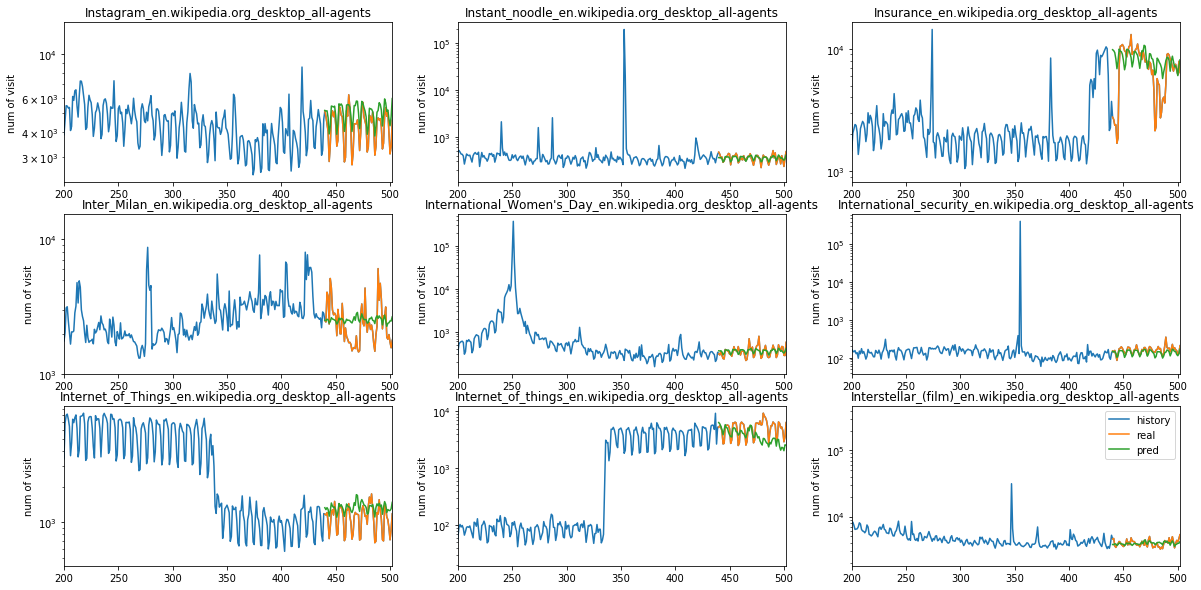

In [0]:
# predY = y_pred0
def draw(idx, offset):
    truePredictPlot = np.empty_like(orig.iloc[idx+offset,1:])
    truePredictPlot[:] = np.nan
    truePredictPlot[test_start : (63 + test_start)] = orig.iloc[idx+offset, test_start+1 : (63 + test_start)+1]
#     truePredictPlot[test_start-1] = orig.iloc[idx+offset,test_start-1]

    testPredictPlot = np.empty_like(orig.iloc[idx+offset, 1:])
    testPredictPlot[:] = np.nan
    testPredictPlot[test_start : (63 + test_start)] = predY[idx+offset,:]
#     testPredictPlot[test_start-1] = orig.iloc[idx+offset, test_start]
    
    plt.subplot(3, 3, idx+1)
    plt.plot(orig.iloc[idx+offset,1:].values, label="history")
    plt.plot(truePredictPlot, label="real")
    plt.plot(testPredictPlot, label="pred")
    plt.yscale("log")
    plt.title(orig.iloc[idx+offset,0])
    #plt.xlabel("days")
    plt.ylabel("num of visit")
    plt.xlim(200,502)

plt.rcParams['figure.figsize'] = [20, 10]
for i in range(9):
    draw(i, 9350)
plt.legend()
plt.show()